In [1]:
!wget https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip

--2022-01-04 14:45:46--  https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip
Resolving dbdmg.polito.it (dbdmg.polito.it)... 130.192.163.163
Connecting to dbdmg.polito.it (dbdmg.polito.it)|130.192.163.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18640208 (18M) [application/zip]
Saving to: ‘DSL2122_january_dataset.zip’

DSL2122_january_dat 100%[===================>]  17.78M  98.2MB/s    in 0.2s    

2022-01-04 14:45:47 (98.2 MB/s) - ‘DSL2122_january_dataset.zip’ saved [18640208/18640208]



In [2]:
!unzip DSL2122_january_dataset.zip

Archive:  DSL2122_january_dataset.zip
   creating: DSL2122_january_dataset/
  inflating: DSL2122_january_dataset/development.csv  
  inflating: __MACOSX/DSL2122_january_dataset/._development.csv  
  inflating: DSL2122_january_dataset/sample_submission.csv  
  inflating: __MACOSX/DSL2122_january_dataset/._sample_submission.csv  
  inflating: DSL2122_january_dataset/evaluation.csv  
  inflating: __MACOSX/DSL2122_january_dataset/._evaluation.csv  


In [4]:
pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 189 kB 5.2 MB/s eta 0:00:01
     |████████████████████████████████| 24.8 MB 66.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, \
 accuracy_score, f1_score, precision_score, recall_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


# nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as sw


# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Word2vec
import gensim


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/students/s292129/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/students/s292129/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/students/s292129/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv('DSL2122_january_dataset/development.csv', index_col=1)

In [ ]:
df.head()

,sentiment,date,flag,user,text
ids,,,,,
1833972543,1,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1980318193,1,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
1994409198,1,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
1824749377,0,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
2001199113,0,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...


# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224994 entries, 1833972543 to 2016018811
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  224994 non-null  int64 
 1   date       224994 non-null  object
 2   flag       224994 non-null  object
 3   user       224994 non-null  object
 4   text       224994 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB


In [ ]:
df.flag.unique()

array(['NO_QUERY'], dtype=object)

There's no need in keep on 'flag' attribute with us.


Let's see if there's some imbalancing:

Text(0.5, 1.0, 'Dataset labels distribution')

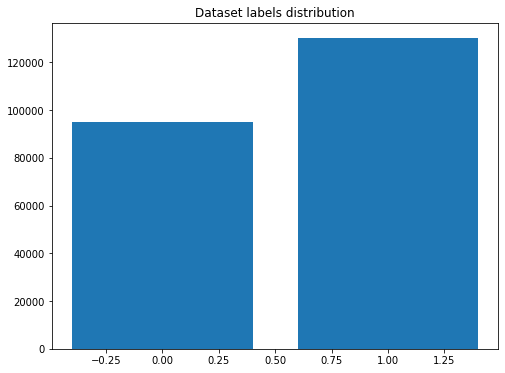

In [ ]:
sentiment_count = Counter(df.sentiment)

plt.figure(figsize=(8,6))
plt.bar(sentiment_count.keys(), sentiment_count.values())
plt.title('Dataset labels distribution')

# First benchmark:

We'll use only the text as features..

In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df.text)

In [ ]:
X_tfidf.shape

(224994, 156707)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.sentiment, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape

((179995, 156707), (179995,))

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Accuracy:  0.702926731705149
f1 score:  0.7437509584419568


# Preprocessing:

Lemmatization and Stopwords elimination:

In [6]:
class LemmaTokenizer(object):
  def __init__(self):
    self.lemmatizer = WordNetLemmatizer()


  def __call__(self, document):
    lemmas = []
    for t in word_tokenize(document):
      t = t.strip()
      lemma = self.lemmatizer.lemmatize(t)
      lemmas.append(lemma)
    return lemmas


lemmaTokenizer = LemmaTokenizer()
vectorizer = TfidfVectorizer(tokenizer=lemmaTokenizer, stop_words=stopwords.words('english'))
X_tfidf = vectorizer.fit_transform(df.text)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  % sorted(inconsistent)


KeyboardInterrupt: ignored

Performances after lemmatization and stopwords elimination:



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.sentiment, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(179995, 173979)

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Accuracy:  0.6928820640458677
f1 score:  0.7392256019322212


Let's try stopword removal only:

you can make a set of stopwords and remove some of the words using the remove function.

stoplist = set(stopwords.words("english")
stoplist.remove('Not').

You can then use this set to filter out the list of stopwords you want.



In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X_tfidf = vectorizer.fit_transform(df.text)

In [ ]:
X_tfidf.shape

(224994, 156563)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.sentiment, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape

((179995, 156563), (179995,))

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Accuracy:  0.7093268739305318
f1 score:  0.7520191104538733


It's clear that lemmatization worsen the performances.. this can happen because abbreviations, like punctuation, can be relevant to sentiment detection.
The problem is that default tokenization used by TfidfVectorizer explicitly ignores all punctuation.

We can modify **token_pattern** in Tfidf_vectorizer to be any character except one or more whitespaces:



In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), token_pattern=r'[^\s]+')
X_tfidf = vectorizer.fit_transform(df.text)
print("Shape after tf-idf: ", X_tfidf.shape)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.sentiment, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Shape after tf-idf:  (224994, 263344)
Accuracy:  0.7001488921976043
f1 score:  0.7436594030814827


If we want to modify the hyperparameters of the tf-idf model, we should tune 


1.   Term frequency weighting. Recall that the term frequency is the normalized count of terms in a given document. This value can be set to:
• b - binary,
• t or n - raw,
• a - augmented,
• l - logarithm,
• d - double logarithm,
• L - log average.

2.   Document frequency weighting. Recall that the document frequency is the number of documents in a corpus that contain a given term. This value can be set to:
• x or n - none,
• f - idf,
• t - zero-corrected idf,
• p - probabilistic idf.
3.   Document normalization. Each document is normalized so that all document vectors are turned into unit vectors. In doing so, we eliminate all information on the length of the original document; this masks some subtleties about longer documents. First, longer documents will — as a result of containing more terms — have higher term frequency values. Second, longer documents contain more distinct terms. The document normalization can be set to:
• x or n - none,
• c - cosine,
• u - pivoted unique,
• b - pivoted character length.





Other preprocessing:

In [7]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused',
          '$_$': 'greedy','@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused','<(-_-)>': 'robot', 'd[-_-]b': 'dj', 
          ":'-)": 'sadsmile',';)': 'wink',';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

punctuations = \
	[	('__PUNC_EXCL',		['!', '¡', ] )	,
		('__PUNC_QUES',		['?', '¿', ] )	,
		('__PUNC_ELLP',		['...', '…', ] ) ]


In [8]:
def preprocess(text):
    processedText = []
    
    # Defining regex patterns.
    urlPattern        = r"(http|https|ftp)://[a-zA-Z0-9\\./]+"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE)

    
    for tweet in text:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL', tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)
        # Replace punctuation.
        for (key, parr) in punctuations:
          for punc in parr:
            if punc in tweet:
              tweet = tweet.replace(punc, key)
        # Replace characters repetitions with two words
        tweet = re.sub(rpt_regex, replace_repet, tweet)
        # Replace all non alphabets.
        #tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        #tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        processedText.append(tweet)
        
    return processedText


def replace_repet(match):
	return match.group(1)+match.group(1)

In [11]:
X_preproc = preprocess(list(df['text']))
y = df['sentiment']

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(X_preproc)
print("Shape after tf-idf: ", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Shape after tf-idf:  (224994, 74271)
Accuracy:  0.7055045667681504
f1 score:  0.7492810655365522


In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), use_idf=False)
X = vectorizer.fit_transform(X_preproc)
print("Shape after tf-idf: ", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Shape after tf-idf:  (224994, 74271)
Accuracy:  0.7053934531878486
f1 score:  0.7505973097544917


Let's try linearSVC:

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), use_idf=False)
X = vectorizer.fit_transform(X_preproc)
print("Shape after tf-idf: ", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Shape after tf-idf:  (224994, 74271)
Accuracy:  0.77397275495011
f1 score:  0.8109725500399576


Let's try Logistic regression with 0.1% test:


In [10]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df.text)
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


reg = LogisticRegression(max_iter = 1000, n_jobs=-1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))

Accuracy:  0.7811111111111111
f1 score:  0.8190070192201683


In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(X_preproc)
print("Shape after tf-idf: ", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_clf = LogisticRegression(max_iter = 5000, n_jobs=-1)
log_clf.fit(X_train,y_train)
y_pred = log_clf.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))


Shape after tf-idf:  (224994, 114534)
Accuracy:  0.7741505366785929
f1 score:  0.8133619818926413


# Preprocessing second approach:

In [43]:
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup


tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()


testing = df.text
result = []
for t in testing:
    result.append(tweet_cleaner(t))


['yes talking helps a lot going through it there s no judgment most sentences end with you know what i mean',
 'sunshine livingg itttt imma lie on the grass listening to oasis reading burnt already',
 'something for your iphone',
 'couldn t get in to the after party',
 'awww is andy being mean again now i want maccas',
 'i m getting so anxious about tomorrow help',
 'the doctors and masters are screwed then',
 'barely been used',
 'hahah it can t work on livejournal',
 'ugh sorry ur sick fresh fruit drinks vits e c b echinacea golden seal rest is nice',
 'boo i hate facebook',
 'i m going for a while now we re off out for a few hours c yah and thanks again for all the birthday wishes',
 'yeah tried sleeping couldn t so supernatural instead',
 'i always remember how to spell rhythm with rhythm has your two hips moving',
 'oh awesome thanks for clarifying and for the kind words we should meet up here at some point',
 'how s it going mate xx',
 'is going to get herhaircut soon going to ge

In [44]:
len(result)

224994

In [45]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(result)
print("Shape after tf-idf: ", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, df.sentiment, test_size=0.1, random_state=42)

log_clf = LogisticRegression(max_iter = 5000, n_jobs=-1)
log_clf.fit(X_train,y_train)
y_pred = log_clf.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))


Shape after tf-idf:  (224994, 77129)


/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1632: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


Accuracy:  0.7768444444444444
f1 score:  0.8151665746364808


In [46]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()


In [48]:
testing = df.text
result = []
for t in testing:
    result.append(tweet_cleaner_updated(t))

In [49]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(result)
print("Shape after tf-idf: ", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, df.sentiment, test_size=0.1, random_state=42)

log_clf = LogisticRegression(max_iter = 5000, n_jobs=-1)
log_clf.fit(X_train,y_train)
y_pred = log_clf.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))


Shape after tf-idf:  (224994, 74696)
Accuracy:  0.7769777777777778
f1 score:  0.815215790248932


# Dealing with class imbalance:

In [30]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
lr = LogisticRegression(max_iter = 1000, n_jobs=-1)

In [32]:

def lr_cv(splits, X, Y, pipeline, average_method):
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X.iloc[train], Y.iloc[train])
        prediction = lr_fit.predict(X.iloc[test])
        scores = lr_fit.score(X.iloc[test],Y.iloc[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y.iloc[test], prediction, average=average_method)*100)
        print('              negative         positive')
        print('precision:', precision_score(Y.iloc[test], prediction, average=None))
        recall.append(recall_score(Y.iloc[test], prediction, average=average_method)*100)
        print('recall:   ', recall_score(Y.iloc[test], prediction, average=None))
        f1.append(f1_score(Y.iloc[test], prediction, average=average_method)*100)
        print('f1 score: ', f1_score(Y.iloc[test], prediction, average=None))
        print('-' * 50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))


In [37]:
original_pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', lr)
])

lr_cv(5, df.text, df.sentiment, original_pipeline, 'macro')


              negative         positive
precision: [0.76599882 0.78707767]
recall:    [0.68534824 0.84745698]
f1 score:  [0.72343267 0.81615212]
--------------------------------------------------
              negative         positive
precision: [0.7706012 0.7861497]
recall:    [0.68186851 0.8521051 ]
f1 score:  [0.72352448 0.81779973]
--------------------------------------------------
              negative         positive
precision: [0.76644502 0.78483395]
recall:    [0.68061999 0.8488725 ]
f1 score:  [0.72098738 0.81559812]
--------------------------------------------------
              negative         positive
precision: [0.76606153 0.78700103]
recall:    [0.68520666 0.84752795]
f1 score:  [0.72338176 0.81614383]
--------------------------------------------------
              negative         positive
precision: [0.76115006 0.78419269]
recall:    [0.68113038 0.84426261]
f1 score:  [0.71892042 0.81311973]
--------------------------------------------------
accuracy: 77.84% (+/- 

We can see that the recall for the negative class is quite low, while the precisions for the negative class are high as. This means the classifier is very picky and does not think many things are negative. All the text it classifies as negative is ~68% of the time really negative.

In [24]:
#SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=42), lr)
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
testing_tfidf = vectorizer.fit_transform(df.text)

smt = SMOTE(random_state=42, sampling_strategy=1, k_neighbors=1, n_jobs=-1)
X_SMOTE, y_SMOTE = smt.fit_resample(testing_tfidf, df.sentiment)
X_train, X_test, y_train, y_test = train_test_split(X_SMOTE,y_SMOTE, test_size=0.1, random_state=42)

#smt_df = pd.DataFrame(X_SMOTE.todense(), columns=vectorizer.get_feature_names())

/home/students/s292129/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1632: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


In [26]:
X_SMOTE.shape

(247298, 156563)

In [21]:
X_train.shape

(202494, 156563)

In [25]:
log_clf = LogisticRegression(max_iter = 5000, n_jobs=-1)
log_clf.fit(X_train, y_train)
y_pred = log_clf.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))


Accuracy:  0.7865345733926405
f1 score:  0.7973123440199653


In [23]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_resample(testing_tfidf, df.sentiment)
print(X_ROS.shape)

X_train, X_test, y_train, y_test = train_test_split(X_ROS, y_ROS, test_size=0.1, random_state=42)


log_clf = LogisticRegression(max_iter = 5000, n_jobs=-1)
log_clf.fit(X_train, y_train)
y_pred = log_clf.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("f1 score: ", f1_score(y_pred=y_pred, y_true=y_test))


(260314, 156563)
Accuracy:  0.7884910878918254
f1 score:  0.7907100501748517


In [ ]:
SMOTE_pipeline = make_pipeline(vectorizer, SMOTE(random_state=42, sampling_strategy=1, k_neighbors=1, n_jobs=-1), lr)
lr_cv(5, df.text, df.sentiment, SMOTE_pipeline, 'macro')

It is believed that SMOTE performs better when combined with undersampling of the majority class, such as random undersampling:

In [42]:
# grid search k value for SMOTE oversampling for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# define dataset
X, y = df.text, df.sentiment
# values to evaluate
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
	# define pipeline
	model = LogisticRegression(max_iter = 5000, n_jobs=-1)
	over = SMOTE(sampling_strategy=0.9, k_neighbors=k)
	under = RandomUnderSampler(sampling_strategy=0.9)
	steps = [('tfidf', vectorizer), ('over', over), ('under', under), ('model', model)]
	pipeline = Pipeline(steps=steps)
	# evaluate pipeline
	cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
	scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=cv, n_jobs=-1)
	score = mean(scores)
	print('> k=%d, F1 score: %.3f' % (k, score))

> k=1, F1 score: 0.768
> k=2, F1 score: 0.768
> k=3, F1 score: 0.768
> k=4, F1 score: 0.768
> k=5, F1 score: 0.768
> k=6, F1 score: 0.768


KeyboardInterrupt: 